# Q-Learning for a gridworld - ACDC2020


## Outline:
* Define the environment
* Define the agent
* Train the agent
* Test the agent performance


## Mount the Google drive:
#### We need to mount the Google drive to import some python classes from it.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import required pachages:

In [0]:
import os
import sys
import gym
import random
import numpy as np

## Add the Google drive directory to the Python path:

In [0]:
working_dir = '/content/drive/My Drive/Colab Notebooks/QLearning_for_gridworld'
sys.path.append(working_dir)

## Import some Python files from the working drirectory:

In [0]:
import visutils
from mdp_meta_data import MdpMetaData
from plot_environment import PlotEnvironment

## Define environment and agent classes

![RL](https://miro.medium.com/max/1400/1*mRq0tF2PHWNArckxPBPpGw.png)

### Environment class

##### In this notebook, the environment is an N*N maze, and an agent lives in the maze. The goal of the agent is to get the goal state from the start state while maximizing the reward or minimizing the punishment.

##### As expected, to create a maze, we need to define its dimensions, start point, goal point, and inner wall. We have already defined these parameters and our default mazes and saved them inside the MdpMetaData class, which we've imported in the previous cell. Here, MDP stands for Markov Decision Process which refers to this tuple (S, A, P, R, gamma).
* S: a set of states
* A: a set of actions
* P(s, a, s'): Transition probability: the probability of moving from the state s to state s' by taking action a at state s.
* R: Reward function
* gamma: discount factor

##### We defined all these parameters as the environment meta data inside the MdpMetaData.

In [0]:
class Environment(gym.core.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, maze_dict=None, default=None):
        self.default = default
        self.mdp_metadate = MdpMetaData(maze_dict, default)
        self.env_dict = self.mdp_metadate.env_dict
        self.n_rows = self.mdp_metadate.n_rows
        self.n_cols = self.mdp_metadate.n_cols

        self.action_space = gym.spaces.Discrete(self.mdp_metadate.num_actions)
        self.observation_space = gym.spaces.Discrete(self.mdp_metadate.num_states)
        self.actions = self.mdp_metadate.actions
        
        self.start_state = self.mdp_metadate.start_state
        self.goal_state = self.mdp_metadate.goal_state
        
        self.inner_wall = self.mdp_metadate.inner_wall
        
        self.T, self.R, self.P = self.mdp_metadate.make_mdp()

        self.S = self.mdp_metadate.goal_state
        
        self.view = PlotEnvironment(self.env_dict)
        self.seed()
        self.reset()
    
    def reset(self):
        # self.reset_frame_counter()
        self.S = self.start_state
        return self.S
    
    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    def move(self, action):
        # print('current s: ', self.S)
        # print('T', self.T.iloc[self.S, action])
        self.new_S = self.T.iloc[self.S, action]
        # print('new s: ', new_S)
        return self.new_S
    
    def step(self, action):
        self.old_S = self.S
        self.S = self.move(action)
        if self.S == self.goal_state:
            reward = 0
            return self.S, reward, True, {}
        else:
            reward = -1
            return self.S, reward, False, {}
    
    def render(self, mode='human'):
        self.metadata["render.frame_counter"] = self.view.plot_map(self.old_S, self.new_S)


### Instantiating and visualizing the environment

In [0]:
# Our environment module consists of two pre-defined maze. Here, we call a 5*5 maze.
env = Environment(maze_dict=None, default=5) 

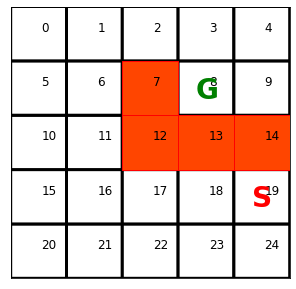

In [7]:
env.view.show_image()

### Agent class

In [0]:
class QAgent():
    def __init__(self, env, gamma=0.97, alpha=0.01, epsilon=1.0):

        #### Here, from the begining the agent knows how many states the env has?
        self.env = env
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.n
        
        #### QL hyperparameters
        self.epsilon = epsilon # exploration rate. Here we start with epsilon=1 and gradually decrese it to 0.1
        self.gamma = gamma # discount factor
        self.alpha = alpha # learning rate
        
        #### Build the Q-table
        self.build_model()
    
    #### A QL agent needs at least these functionalities

    ##### Q table
    def build_model(self):
        self.q_table = 1e-4 * np.random.random([self.state_size, self.action_size])
        self.q_table[self.env.goal_state, :] = 0
        for w in self.env.inner_wall:
            self.q_table[w, :] = np.nan
    
    ##### A policy for action selection based on the available information (Q values)
    def get_action(self, state, policy='e_greedy'):
        q_state = self.q_table[state]
        if policy == 'e_greedy':
            action_greedy = np.argmax(q_state)
            action_random = random.choice(range(self.action_size))
            action = action_random if random.random() < self.epsilon else action_greedy
        return action
    
    ##### Updating the Q table based on the recently acquired information
    def train(self, experience):
        state, action, next_state, reward, done = experience
        q_next = self.q_table[next_state] * (1 - done)
        q_max = np.max(q_next)
        q_target = reward + self.gamma * q_max
        q_update = q_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * q_update
        
        if done:
            self.epsilon = max(0.1, 0.998 * self.epsilon)

#### Q-tabel

![Q-table](https://techs0uls.files.wordpress.com/2020/01/qtable.png?w=508)


#### epsilon-greedy policy

![e-greedy policy](https://www.oreilly.com/library/view/hands-on-reinforcement-learning/9781788836524/assets/9ae532cc-2655-4fd0-bcd2-545afc27a1df.png)

#### Q-learning update rule

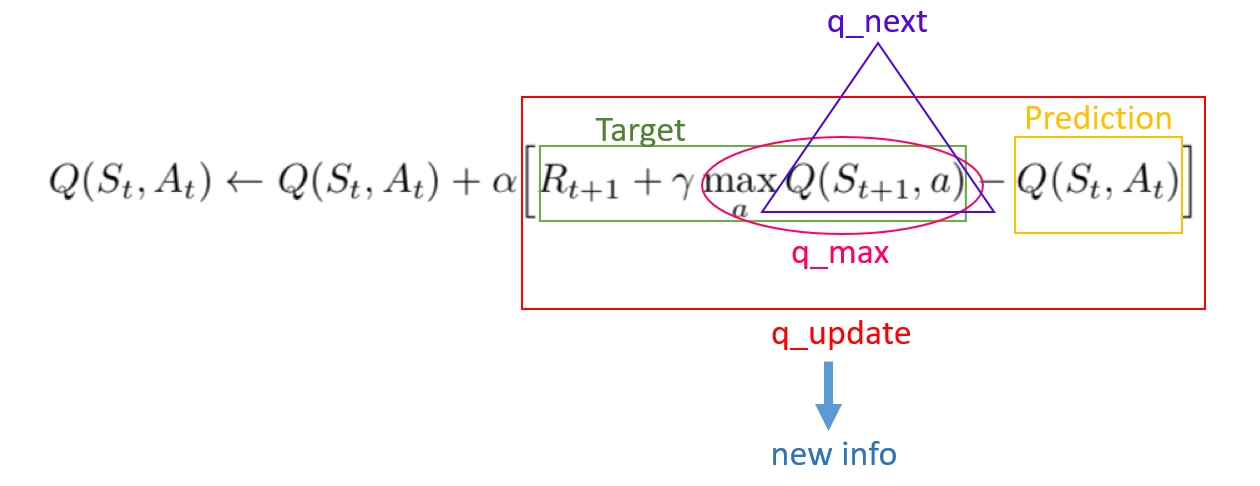

In [9]:
from PIL import Image
Image.open('/content/drive/My Drive/Colab Notebooks/QLearning_for_gridworld/QL.png')

### Define a helper function for visualization

In [0]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [0]:
### This render function if for visualizing the agent performance in the notebook. 
### Within the Python code, you do not need this function, instead you can just the env.render().
def rendering(t, env, cur_state, new_state):
    pltdata = env.view
    if t == 1:
        pltdata.fig, pltdata.ax = plt.subplots(figsize=(5,5))
        plt.xticks([])
        plt.yticks([])
        c = pltdata.ax.pcolor(pltdata.chessboard, edgecolors='k', linewidths=3, cmap='binary')

        for p in range(pltdata.bsize):
          pltdata.ax.text(pltdata.tp2cl(p)[1]+0.55, pltdata.tp2cl(p)[0]+0.55, str(p), fontsize=12)

        pltdata.ax.text(pltdata.p2c(pltdata.start_state)[1]+0.32, pltdata.p2c(pltdata.start_state)[0]+0.32, 'S', fontsize=28, color='red', fontweight='bold')
        pltdata.ax.text(pltdata.p2c(pltdata.goal_state)[1]+0.32, pltdata.p2c(pltdata.goal_state)[0]+0.32, 'G', fontsize=28, color='green', fontweight='bold')

        for t in range(pltdata.n_blocked_cells):    
            rect_xy = pltdata.wall_cell_coords[t]
            COLOR = pltdata.EVEN_COLOR if t % 2 == 0 else pltdata.ODD_COLOR 
            rect = patches.Rectangle((rect_xy[1]+pltdata.rect_shift_x, rect_xy[0]+pltdata.rect_shift_y), pltdata.rect_w, pltdata.rect_h, linewidth=1, edgecolor='r', facecolor=COLOR)
            pltdata.ax.add_patch(rect)

    
    arrow_start = np.array(pltdata.tp2cl(cur_state)) + 0.5
    arrow_stop = np.array(pltdata.tp2cl(new_state)) + 0.5
    diff = (arrow_stop[0] - arrow_start[0], arrow_stop[1] - arrow_start[1])
    COLOR = (np.random.rand(), np.random.rand(), np.random.rand())
    if not np.array_equal(arrow_start, arrow_stop):
        pltdata.ax.arrow(arrow_start[1], arrow_start[0], diff[1], diff[0], head_width=0.2, head_length=0.2, fc=COLOR, ec=COLOR)

    time.sleep(0.5)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Instantiate the agent

In [0]:
agent = QAgent(env) 

## Train Q-Learning Agent

In [0]:
def train_AQgent(env, agent, n_episodes=2400, render=False):
  total_reward = []
  view_freq = 500
  obs_history = {ep:[] for ep in range(n_episodes)}
  for ep in range(n_episodes):
      if ep % view_freq == 0:
          print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          obs_history[ep].append(state)
          action = agent.get_action(state)
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          agent.train(experience)
          episode_reward.append(reward)        
          
          # experience_list = list(experience)
          # for str_a, int_a in env.actions.items():  
          #     if action == int_a:
          #         experience_list[1] = str_a
          # print('Experience: ', experience_list)
          
          if render:
            print("comment the following 3 lines to prevernt visualiztion and decrease the computation time")
            if ep in [1000, 2000]:
              print(f'The agent navigation in episode {ep}.')
              rendering(t, env, state, next_state) 
          
          state = next_state
          
          if done:
              if ep % view_freq == 0:
                  print("Episode finished after {} timesteps".format(t))
                  print("Current epsilon is: ", agent.epsilon)
                  print('Episode Reward: {}'.format(np.sum(episode_reward)))
              break
      total_reward.append(np.sum(episode_reward))
  return agent.q_table, total_reward, obs_history

In [14]:
agent.q_table, total_reward, obs_history = train_AQgent(env, agent, n_episodes=2400, render=False)

---------- The episode number is:  0
Episode finished after 689 timesteps
Current epsilon is:  0.998
Episode Reward: -688
---------- The episode number is:  500
Episode finished after 15 timesteps
Current epsilon is:  0.36677623234744455
Episode Reward: -14
---------- The episode number is:  1000
Episode finished after 9 timesteps
Current epsilon is:  0.13479439340178997
Episode Reward: -8
---------- The episode number is:  1500
Episode finished after 11 timesteps
Current epsilon is:  0.1
Episode Reward: -10
---------- The episode number is:  2000
Episode finished after 9 timesteps
Current epsilon is:  0.1
Episode Reward: -8


#### Plot the total reward per episode

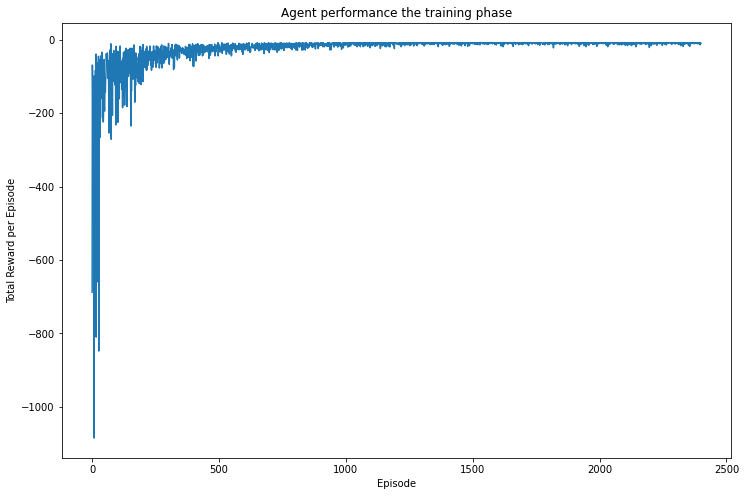

In [15]:
visutils.plot_reward(total_reward)

#### Check the agent performance in some episodes:

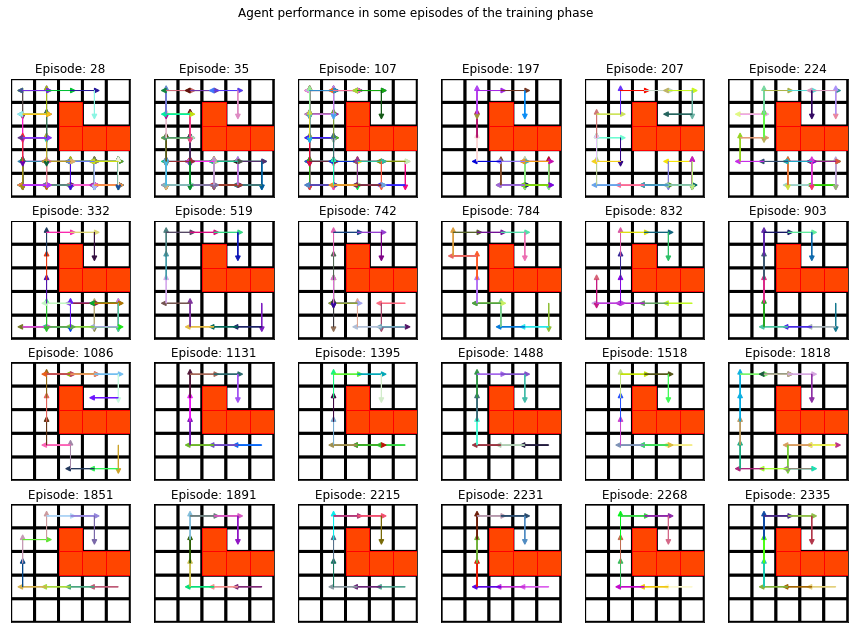

In [16]:
visutils.plot_obs_history(env, obs_history)

## Test Q-Learning Agent

In [0]:
def test_QAgent(env, agent, n_episodes, render=True):
  q_table = agent.q_table
  total_reward = []
  for ep in range(n_episodes):
      print('========================================')
      print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          action = np.argmax(q_table[state])
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          # print('Experience: ', experience)
          episode_reward.append(reward)        

          agent.train(experience)

          if render:
                rendering(t, env, state, next_state)
          
          state = next_state

          if done:
              print("Episode finished after {} timesteps".format(t))
              break

      total_reward.append(np.sum(episode_reward))
      print('Episode Reward: {}'.format(np.sum(episode_reward)))

Episode finished after 9 timesteps
Episode Reward: -8


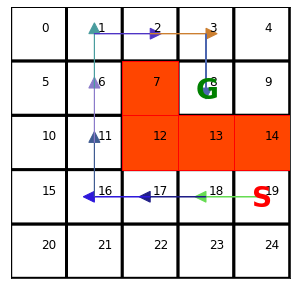

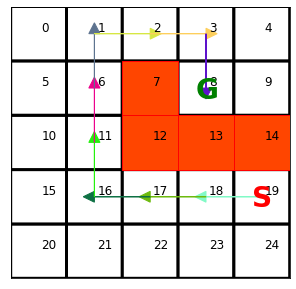

In [18]:
test_QAgent(env, agent, n_episodes=2)

# Assignment

#### When you instantiate the environment class, you can change its structure by passing new parameters. For example, the next cell shows how to define a new 8*8 maze.  

In [0]:
maze_dict = {'n_rows':8, 'n_cols':8, 
            'inner_wall_coords':[[1,2],[1,3],[1,4],[1,5],[2,2],[3,2],[3,3],[3,4],[3,5],[5,2],[5,3],[5,4],[6,4], [7,2],[7,3],[7,4]], 
            'startRow':6, 'startCol':3, 
            'goalRow':2, 'goalCol':3}
env = Environment(maze_dict)


#### Then you can plot the image of your maze:

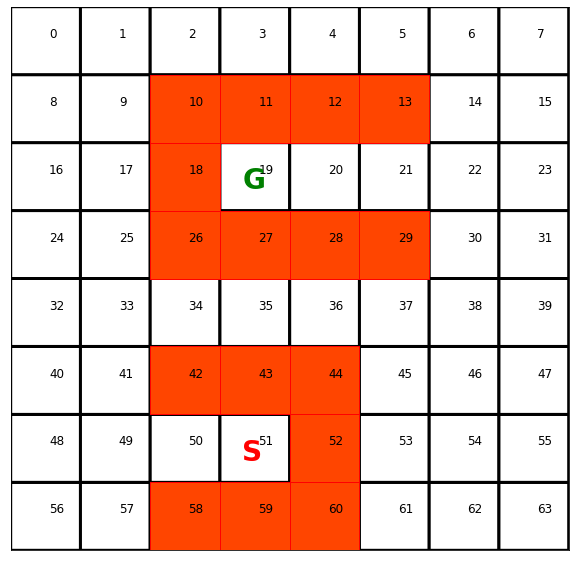

In [20]:
PlotEnvironment(env.env_dict).show_image()

#### For the assignment, your task is to:
* define a new environment
* train the Q-learning to find the best policy by:
  * changing Q-Learning hyperparamers
  * changing the training parameters like the number of episodes and epsilon
  * modifying the reward funciton

#### There is also a test 10*10 maze, which you can call it as follows:

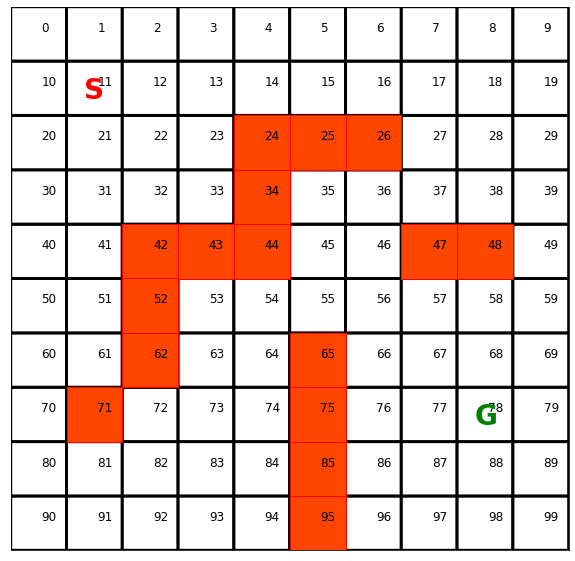

In [21]:
from gridworld_environment import Environment
from plot_environment import PlotEnvironment
env = Environment(default=10)
PlotEnvironment(env.env_dict).show_image()

## Enjoy your journey in studying Reinforcement Learning ...